# Preface

The dataset comes from the UCI Machine Learning repository, and it is related to direct marketing campaigns (phone calls) of a Portuguese banking institution. 

The classification goal is to predict whether the client will subscribe (1/0) to a term deposit (variable y).

Aim of this notebook is to explore parameter tuning and model boosting techniques

Based on XGB parameter tuning guide:
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

Data preprocessing is enclosed in deposit_data_prep.ipynb 

keys: RFE, SMOTE, outliers detection

# Loading Data and Basic Data Inspection

In [185]:
# load data 
train_data = pd.read_csv('deposit_train.csv')
test_data = pd.read_csv('deposit_test.csv')

target = 'y'
X_train = train_data.drop(columns = [target, 'Unnamed: 0']) # Unnamed: 0 column reveals after reading of csv
y_train = train_data[target]

X_test = test_data.drop(columns = [target, 'Unnamed: 0']) # Unnamed: 0 column reveals after reading of csv
y_test = test_data[target]

# Import xgboost and metrics

In [8]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

#Additional scklearn functions
from sklearn import metrics   
from sklearn.model_selection import cross_val_score, KFold, cross_validate
from sklearn.model_selection import GridSearchCV # Perforing grid search

In [248]:
# modified and updated original function
def modelfit(alg, data_X, data_y, test_X, test_y, model_name, show_report=False, f_importance=False, useTrainCV=False, cv_folds=5, early_stopping_rounds=50):
    starttime = dt.now()

    """
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    """
    #Fit the algorithm on the data
    alg.fit(data_X, data_y, eval_metric='logloss')
        
    #Predict training set:
    dtrain_predictions = alg.predict(data_X)
    dtrain_predprob = alg.predict_proba(data_X)[:,1]
    
    #     Predict on testing data:
    test_predprob = alg.predict_proba(test_X)[:,1]
    test_predictions = alg.predict(test_X)
    
    endtime = dt.now()    
    duration = endtime - starttime

    report ={
        'model_name': [model_name],
        'train_accuracy'  : [metrics.accuracy_score(data_y.values, dtrain_predictions)],
        'auc_train' : [metrics.roc_auc_score(data_y, dtrain_predprob)],
        'test_accuracy'  : [metrics.accuracy_score(test_y, test_predictions)],
        'auc_test' :  [metrics.roc_auc_score(test_y, test_predprob)],
        'tr_time'   : [duration],
        'LR' : [alg.learning_rate],
        'n_estimators':[alg.n_estimators],
        'depth':[alg.max_depth],
        'subsample':[alg.subsample],
        'colsample_bytree': [alg.colsample_bytree]
    }
    #Print model report:
    if show_report:
        print("\nModel Report")
        print("Accuracy (Train) : %.4g" % report['train_accuracy'][0])
        print("AUC Score (Train): %f" % report['auc_train'][0])
        print("Accuracy (Test): %.4g" % report['test_accuracy'][0])
        print('AUC Score (Test): %f' % report['auc_test'][0])
        print("Model training took", str(report['tr_time'][0]))
        
        
        if f_importance:
            feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
            feat_imp.plot(kind='bar', title='Feature Importances')
            plt.ylabel('Feature Importance Score')
    
    
    
    return report
    
# dataframe to write down tuning process info
#results_df = pd.DataFrame()

# General description of parameters

### Gridsearch tuning
- #### min_child_weight [default=1]
Defines the minimum sum of weights of all observations required in a child.
Used to control over-fitting. Higher values prevent a model from learning relations.
Too high values can lead to under-fitting hence, it should be tuned using CV.
- #### max_depth [default=6]
The maximum depth of a tree, same as GBM.
Should be tuned using CV.
Typical values: 3-10
- #### gamma [default=0]
minimum loss reduction required to make a split.
Should be tuned using CV.
- #### max_delta_step [default=0]
In maximum delta step we allow each tree’s weight estimation to be. If the value is set to 0, it means there is no constraint. If it is set to a positive value, it can help making the update step more conservative.
Used for imbalanced datasets

### Manual tuning
- #### learning_rate
Typical final values to be used: 0.01-0.2
- #### max_leaf_nodes
The maximum number of terminal nodes or leaves in a tree.
- #### subsample [default=1]
Denotes the fraction of observations to be randomly samples for each tree.
Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.
Typical values: 0.5-1
- #### colsample_bytree [default=1]
Similar to max_features in GBM. Denotes the fraction of columns to be randomly samples for each tree.
Typical values: 0.5-1
- #### colsample_bylevel [default=1]
Denotes the subsample ratio of columns for each split, in each level.
- #### lambda [default=1] (not used)
L2 regularization term on weights (analogous to Ridge regression)
- #### alpha [default=0] (not used)
L1 regularization term on weight (analogous to Lasso regression)
- #### scale_pos_weight [default=1]
A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence.
- #### nthread [default to maximum number of threads available if not set]
Number of parallel threads used to run XGBoost

In [189]:
# defining baseline model

xgb1 = XGBClassifier(
        learning_rate =0.5,
        n_estimators=200,
        max_depth=4,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)


Model Report
Accuracy : 0.953
AUC Score (Train): 0.993183
AUC Score (Test): 0.942244
Model training took 0:00:03.900655


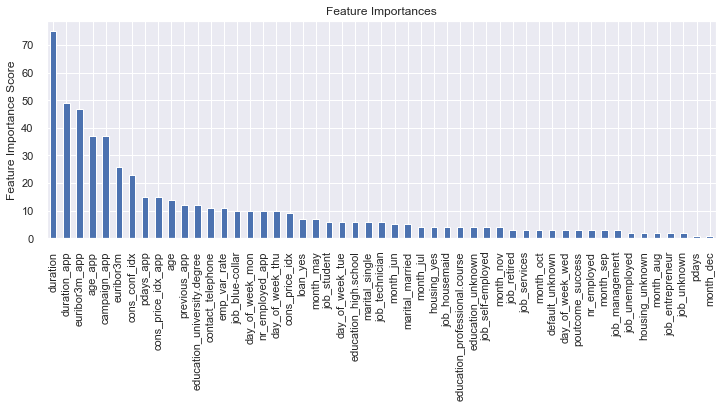

In [210]:
# model 1
label = 'baseline'
m_report = modelfit(xgb1, X_train, y_train, X_test, y_test, label, show_report=True, f_importance=True)
modelfit_df = pd.DataFrame.from_dict(m_report)
results_df = results_df.append(modelfit_df)

In [212]:
estimators_range = [40, 50, 100, 200, 400, 600] # to check for learning rate 0.5
for estimators in estimators_range:
    xgb1.n_estimators = 40
    m_report = modelfit(xgb1, X_train, y_train, X_test, y_test, label, show_report=True, f_importance=False)
    modelfit_df = pd.DataFrame.from_dict(m_report)
    results_df = results_df.append(modelfit_df)
    print('model for % estimators trained' % estimators)


Model Report
Accuracy : 0.953
AUC Score (Train): 0.993183
AUC Score (Test): 0.942244
Model training took 0:00:04.105435


In [228]:
# Defing optimal LR*N_est value 
results_df['mean_acc'] = (results_df['accuracy']+results_df['test_accuracy'])/2
results_df['mean_auc'] = (results_df['auc_train']+results_df['auc_test'])/2

results_df.sort_values('mean_auc', ascending=False)
lr_to_est_df = results_df.sort_values('mean_auc', ascending=False)
display(lr_to_est_df)

# optimal LR*N_est = 100
# to high estiators cause overfitting and much higher training time
# models with less estimators predict test data better  

,model_name,accuracy,auc_train,auc_test,test_accuracy,tr_time,LR,n_estimators,depth,subsample,mean_acc,mean_auc
0,baseline,0.975372,0.997673,0.942977,0.909091,00:00:16.488244,0.5,200,4,0.8,0.942232,0.970325
0,baseline,0.987882,0.999306,0.940354,0.911115,00:00:33.305582,0.5,400,4,0.8,0.949498,0.969830
0,baseline,0.964524,0.995661,0.943795,0.912491,00:00:08.959615,0.5,100,4,0.8,0.938508,0.969728
0,baseline,0.955670,0.993803,0.943909,0.912734,00:00:04.919893,0.5,50,4,0.8,0.934202,0.968856
0,baseline,0.994371,0.999806,0.937494,0.908848,00:00:47.167983,0.5,600,4,0.8,0.951609,0.968650
0,baseline,0.952953,0.993183,0.942244,0.910710,00:00:03.900655,0.5,40,4,0.8,0.931832,0.967713
0,baseline,0.952953,0.993183,0.942244,0.910710,00:00:04.105435,0.5,40,4,0.8,0.931832,0.967713


In [229]:
# confirm baseline model

xgb1 = XGBClassifier(
        learning_rate =0.5,
        n_estimators=200,
        max_depth=4,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)

In [230]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols

param_test1 = {
    'max_depth':range(2,10,2),
    'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb1, param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
starttime = dt.now()

gsearch1.fit(X_train, y_train)

endtime = dt.now()    
duration = endtime - starttime
print('Grid search took:', duration)    

E:\Programs\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



Grid search took: 0:09:48.210801


In [276]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols

param_test1 = {
    'min_child_weight':[0.5, 0.7, 0.8, 0.9, 1]
}
gsearch1 = GridSearchCV(estimator = xgb1, param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
starttime = dt.now()

gsearch1.fit(X_train, y_train)

endtime = dt.now()    
duration = endtime - starttime
print('Grid search took:', duration)    

Grid search took: 0:06:06.176475


### Displaying results of cross validatiion grid search on: 
- max_depth [2, 8]
- min_child_weight [1, 5]

In [231]:
print(gsearch1)
print(gsearch1.cv_results_)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.5, max_delta_step=None,
                                     max_depth=4, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=200, n...
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=1,
                                     seed=27, subsample=0.8, tree_meth

In [232]:
print(gsearch1.best_params_)
print(gsearch1.best_score_)

{'max_depth': 8, 'min_child_weight': 1}
0.988381607338568


In [234]:
best_max_depth = 8
best_min_child_weight = 1

In [241]:
xgb1.max_depth = best_max_depth
xgb1.min_child_weight = best_min_child_weight

In [242]:
param_test1 = {
    'gamma': [i*0.1 for i in range(6)]
}
gsearch_gamma = GridSearchCV(estimator = xgb1, param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
starttime = dt.now()

gsearch_gamma.fit(X_train, y_train)

endtime = dt.now()    
duration = endtime - starttime
print('Grid search took:', duration)    

Grid search took: 0:07:00.881248


In [243]:
print(gsearch_gamma.best_params_)
print(gsearch_gamma.best_score_)
# for max_depth = 8 best gamma is 0, however using max_depth = 4 best gamma is 0.5

{'gamma': 0.0}
0.988381607338568


In [244]:
# Setting kfold for future use
kf = KFold(5, random_state=42, shuffle=True)

In [249]:
tuning_df = pd.DataFrame()

label = 'baseline GS'
report = modelfit(xgb1, X_train, y_train, X_test, y_test, label, show_report=True, f_importance=False)
report_df = pd.DataFrame.from_dict(report)
tuning_df = tuning_df.append(report_df)
print('Baseline gridserach model trained')
display(tuning_df)


Model Report
Accuracy (Train) : 1
AUC Score (Train): 1.000000
Accuracy (Test): 0.9076
AUC Score (Test): 0.937611
Model training took 0:00:18.656628
Baseline gridserach model trained


,model_name,train_accuracy,auc_train,test_accuracy,auc_test,tr_time,LR,n_estimators,depth,subsample,colsample_bytree
0,baseline GS,0.99998,1.0,0.907553,0.937611,00:00:18.656628,0.5,200,8,0.8,0.8


In [256]:
# training subsample
subsample_range = [0.4, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9]

for subsamp in subsample_range:
    label = 'subsample {0}'.format(subsamp)
    xgb1.subsample = subsamp
    report = modelfit(xgb1, X_train, y_train, X_test, y_test, label, show_report=True, f_importance=False)
    report_df = pd.DataFrame.from_dict(report)
    tuning_df = tuning_df.append(report_df)
    print('Model trained: '+label)



Model Report
Accuracy (Train) : 0.999
AUC Score (Train): 0.999996
Accuracy (Test): 0.9043
AUC Score (Test): 0.930821
Model training took 0:00:21.775902
Model trained: subsample 0.4

Model Report
Accuracy (Train) : 1
AUC Score (Train): 1.000000
Accuracy (Test): 0.9088
AUC Score (Test): 0.938177
Model training took 0:00:23.362845
Model trained: subsample 0.6

Model Report
Accuracy (Train) : 1
AUC Score (Train): 1.000000
Accuracy (Test): 0.9067
AUC Score (Test): 0.936420
Model training took 0:00:20.262606
Model trained: subsample 0.7

Model Report
Accuracy (Train) : 1
AUC Score (Train): 1.000000
Accuracy (Test): 0.9082
AUC Score (Test): 0.939405
Model training took 0:00:19.057719
Model trained: subsample 0.75

Model Report
Accuracy (Train) : 1
AUC Score (Train): 1.000000
Accuracy (Test): 0.9076
AUC Score (Test): 0.937611
Model training took 0:00:17.369531
Model trained: subsample 0.8

Model Report
Accuracy (Train) : 1
AUC Score (Train): 1.000000
Accuracy (Test): 0.9098
AUC Score (Test): 

In [260]:
display(tuning_df.sort_values('test_accuracy', ascending=False))


,model_name,train_accuracy,auc_train,test_accuracy,auc_test,tr_time,LR,n_estimators,depth,subsample,colsample_bytree
0,subsample 0.85,1.000000,1.000000,0.909819,0.938778,00:00:16.917057,0.5,200,8,0.85,0.8
0,subsample 0.9,1.000000,1.000000,0.909334,0.938808,00:00:16.337284,0.5,200,8,0.90,0.8
0,subsample 0.6,0.999961,1.000000,0.908767,0.938177,00:00:23.362845,0.5,200,8,0.60,0.8
0,subsample 0.75,1.000000,1.000000,0.908200,0.939405,00:00:19.057719,0.5,200,8,0.75,0.8
0,baseline GS,0.999980,1.000000,0.907553,0.937611,00:00:18.656628,0.5,200,8,0.80,0.8
0,subsample 0.8,0.999980,1.000000,0.907553,0.937611,00:00:17.369531,0.5,200,8,0.80,0.8
0,subsample 0.7,0.999961,1.000000,0.906743,0.936420,00:00:20.262606,0.5,200,8,0.70,0.8
0,subsample 0.4,0.998984,0.999996,0.904315,0.930821,00:00:21.775902,0.5,200,8,0.40,0.8


In [261]:
best_subsample = 0.85
xgb1.subsample= best_subsample

In [262]:
# training subsample
colsample_bytree_range = [0.4, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9]

for colsample in subsample_range:
    label = 'colsample_bytree {0}'.format(colsample)
    xgb1.colsample_bytree = colsample
    report = modelfit(xgb1, X_train, y_train, X_test, y_test, label, show_report=False, f_importance=False)
    
    report_df = pd.DataFrame.from_dict(report)
    tuning_df = tuning_df.append(report_df)
    print('Model trained: '+label)

Model trained: colsample_bytree 0.4
Model trained: colsample_bytree 0.6
Model trained: colsample_bytree 0.7
Model trained: colsample_bytree 0.75
Model trained: colsample_bytree 0.8
Model trained: colsample_bytree 0.85
Model trained: colsample_bytree 0.9


In [263]:
display(tuning_df.sort_values('test_accuracy', ascending=False))


,model_name,train_accuracy,auc_train,test_accuracy,auc_test,tr_time,LR,n_estimators,depth,subsample,colsample_bytree
0,colsample_bytree 0.85,1.000000,1.000000,0.911115,0.938971,00:00:17.211953,0.5,200,8,0.85,0.85
0,colsample_bytree 0.4,0.999922,1.000000,0.909900,0.941211,00:00:12.268086,0.5,200,8,0.85,0.40
0,colsample_bytree 0.6,0.999980,1.000000,0.909900,0.939524,00:00:14.569025,0.5,200,8,0.85,0.60
0,subsample 0.85,1.000000,1.000000,0.909819,0.938778,00:00:16.917057,0.5,200,8,0.85,0.80
0,colsample_bytree 0.8,1.000000,1.000000,0.909819,0.938778,00:00:16.571664,0.5,200,8,0.85,0.80
0,colsample_bytree 0.9,1.000000,1.000000,0.909577,0.938402,00:00:17.829302,0.5,200,8,0.85,0.90
0,subsample 0.9,1.000000,1.000000,0.909334,0.938808,00:00:16.337284,0.5,200,8,0.90,0.80
0,subsample 0.6,0.999961,1.000000,0.908767,0.938177,00:00:23.362845,0.5,200,8,0.60,0.80
0,colsample_bytree 0.7,1.000000,1.000000,0.908605,0.939228,00:00:15.466621,0.5,200,8,0.85,0.70
0,colsample_bytree 0.75,1.000000,1.000000,0.908524,0.939354,00:00:16.260499,0.5,200,8,0.85,0.75


In [264]:
best_colsample_bytree = 0.85
xgb1.colsample_bytree = best_colsample_bytree

In [265]:
# looking over parameters
xgb1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.85, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=4, nthread=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=27, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=27, subsample=0.85,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [267]:
# training subsample
nthread_range = [3, 4, 5, 6, 7, 8]

for thread in nthread_range:
    label = 'nthread = {0}'.format(thread)
    xgb1.nthread = thread
    report = modelfit(xgb1, X_train, y_train, X_test, y_test, label, show_report=False, f_importance=False)
    
    report_df = pd.DataFrame.from_dict(report)
    tuning_df = tuning_df.append(report_df)
    print('Model trained: {0}'.format(label))

Model trained: nthread = 3
Model trained: nthread = 4
Model trained: nthread = 5
Model trained: nthread = 6
Model trained: nthread = 7
Model trained: nthread = 8


In [274]:
# training subsample
nthread_range = [10]

for thread in nthread_range:
    label = 'nthread = {0}'.format(thread)
    xgb1.nthread = thread
    report = modelfit(xgb1, X_train, y_train, X_test, y_test, label, show_report=False, f_importance=False)
    
    report_df = pd.DataFrame.from_dict(report)
    tuning_df = tuning_df.append(report_df)
    print('Model trained: {0}'.format(label))

Model trained: nthread = 10


In [275]:
display(tuning_df.sort_values('test_accuracy', ascending=False))


,model_name,train_accuracy,auc_train,test_accuracy,auc_test,tr_time,LR,n_estimators,depth,subsample,colsample_bytree
0,nthread = 10,1.000000,1.000000,0.911115,0.938971,00:00:21.299052,0.5,200,8,0.85,0.85
0,nthread = 6,1.000000,1.000000,0.911115,0.938971,00:00:19.123469,0.5,200,8,0.85,0.85
0,nthread = 4,1.000000,1.000000,0.911115,0.938971,00:00:21.977509,0.5,200,8,0.85,0.85
0,nthread = 3,1.000000,1.000000,0.911115,0.938971,00:00:21.455225,0.5,200,8,0.85,0.85
0,nthread = 7,1.000000,1.000000,0.911115,0.938971,00:00:19.620992,0.5,200,8,0.85,0.85
0,colsample_bytree 0.85,1.000000,1.000000,0.911115,0.938971,00:00:17.211953,0.5,200,8,0.85,0.85
0,nthread = 8,1.000000,1.000000,0.911115,0.938971,00:00:18.921840,0.5,200,8,0.85,0.85
0,nthread = 10,1.000000,1.000000,0.911115,0.938971,00:00:18.776228,0.5,200,8,0.85,0.85
0,nthread = 5,1.000000,1.000000,0.911115,0.938971,00:00:21.343647,0.5,200,8,0.85,0.85
0,nthread = 12,1.000000,1.000000,0.911115,0.938971,00:00:18.916164,0.5,200,8,0.85,0.85


# Step 3: Making models with lower learning rate
Finally, we have all the parameters needed. Now, we need to lower the learning rate and increase the number of estimators proportionally. 

**Note:** These trees might not be the most optimum values but a good benchmark.

So we see the best GBM classifier to perform with the parameters below

- learning rate: 0.5
- number of estimators: 200
- colsample_bytree = 0.85
- subsample = 0.85
- min_child_weight = 1
- best_min_samples_leaf = 40
- best_max_depth = 8
- gamma = 0


In [279]:
xgb1.learning_rate = 0.2
xgb1.n_estimators = 500

label = 'LR = {0}'.format(xgb1.learning_rate)
print('Training model {0}'.format(label))
report = modelfit(xgb1, X_train, y_train, X_test, y_test, label, show_report=True, f_importance=False)
report_df = pd.DataFrame.from_dict(report)
tuning_df = tuning_df.append(report_df)



Training model LR = 0.2


KeyboardInterrupt: 

In [280]:
display(tuning_df.sort_values('test_accuracy', ascending=False))

,model_name,train_accuracy,auc_train,test_accuracy,auc_test,tr_time,LR,n_estimators,depth,subsample,colsample_bytree
0,LR = 0.2,1.000000,1.000000,0.912977,0.942696,00:00:49.698774,0.2,500,8,0.85,0.85
0,LR = 0.2,1.000000,1.000000,0.912977,0.942696,00:00:50.485599,0.2,500,8,0.85,0.85
0,nthread = 4,1.000000,1.000000,0.911115,0.938971,00:00:21.977509,0.5,200,8,0.85,0.85
0,nthread = 10,1.000000,1.000000,0.911115,0.938971,00:00:21.299052,0.5,200,8,0.85,0.85
0,nthread = 20,1.000000,1.000000,0.911115,0.938971,00:00:20.012201,0.5,200,8,0.85,0.85
0,nthread = 18,1.000000,1.000000,0.911115,0.938971,00:00:20.038044,0.5,200,8,0.85,0.85
0,nthread = 16,1.000000,1.000000,0.911115,0.938971,00:00:20.147116,0.5,200,8,0.85,0.85
0,nthread = 14,1.000000,1.000000,0.911115,0.938971,00:00:26.911197,0.5,200,8,0.85,0.85
0,nthread = 12,1.000000,1.000000,0.911115,0.938971,00:00:18.916164,0.5,200,8,0.85,0.85
0,nthread = 10,1.000000,1.000000,0.911115,0.938971,00:00:18.776228,0.5,200,8,0.85,0.85


In [281]:
xgb1.learning_rate = 0.1
xgb1.n_estimators = 1000

label = 'LR = {0}'.format(xgb1.learning_rate)
print('Training model {0}'.format(label))
report = modelfit(xgb1, X_train, y_train, X_test, y_test, label, show_report=True, f_importance=False)
report_df = pd.DataFrame.from_dict(report)
tuning_df = tuning_df.append(report_df)

Training model LR = 0.1

Model Report
Accuracy (Train) : 1
AUC Score (Train): 1.000000
Accuracy (Test): 0.9138
AUC Score (Test): 0.944493
Model training took 0:01:44.017133


In [283]:
xgb1.learning_rate = 0.05
xgb1.n_estimators = 2000

label = 'LR = {0}'.format(xgb1.learning_rate)
print('Training model {0}'.format(label))
report = modelfit(xgb1, X_train, y_train, X_test, y_test, label, show_report=True, f_importance=False)
report_df = pd.DataFrame.from_dict(report)
tuning_df = tuning_df.append(report_df)

Training model LR = 0.05

Model Report
Accuracy (Train) : 1
AUC Score (Train): 1.000000
Accuracy (Test): 0.9133
AUC Score (Test): 0.944461
Model training took 0:03:34.707734


In [284]:
display(tuning_df.sort_values('test_accuracy', ascending=False))

,model_name,train_accuracy,auc_train,test_accuracy,auc_test,tr_time,LR,n_estimators,depth,subsample,colsample_bytree
0,LR = 0.1,0.999980,1.000000,0.913786,0.944493,00:01:44.017133,0.10,1000,8,0.85,0.85
0,LR = 0.05,1.000000,1.000000,0.913300,0.944461,00:03:34.707734,0.05,2000,8,0.85,0.85
0,LR = 0.2,1.000000,1.000000,0.912977,0.942696,00:00:49.698774,0.20,500,8,0.85,0.85
0,LR = 0.2,1.000000,1.000000,0.912977,0.942696,00:00:50.485599,0.20,500,8,0.85,0.85
0,nthread = 5,1.000000,1.000000,0.911115,0.938971,00:00:21.343647,0.50,200,8,0.85,0.85
0,nthread = 10,1.000000,1.000000,0.911115,0.938971,00:00:21.299052,0.50,200,8,0.85,0.85
0,nthread = 20,1.000000,1.000000,0.911115,0.938971,00:00:20.012201,0.50,200,8,0.85,0.85
0,nthread = 18,1.000000,1.000000,0.911115,0.938971,00:00:20.038044,0.50,200,8,0.85,0.85
0,nthread = 16,1.000000,1.000000,0.911115,0.938971,00:00:20.147116,0.50,200,8,0.85,0.85
0,nthread = 14,1.000000,1.000000,0.911115,0.938971,00:00:26.911197,0.50,200,8,0.85,0.85


In [285]:
xgb_top = xgb1

# Predicting with the best model

In [288]:
# predict on the out-of-sample (testing) set
y_pred = xgb_top.predict(X_test)
print('Accuracy of the classifier on test set: {:.3f}'.format(xgb_top.score(X_test, y_test.values.ravel())))

Accuracy of the classifier on test set: 0.913


## Confusion Matrix:

In [289]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[10484   472]
 [  599   798]]


## Compute precision, recall, F-measure and support
To quote from Scikit Learn:

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

The F-beta score weights the recall more than the precision by a factor of beta. beta = 1.0 means recall and precision are equally important.

The support is the number of occurrences of each class in y_test.

In [290]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95     10956
           1       0.63      0.57      0.60      1397

    accuracy                           0.91     12353
   macro avg       0.79      0.76      0.77     12353
weighted avg       0.91      0.91      0.91     12353



## Interpretation
Of the entire test set, 91.3% of the promoted term deposit were predicted accurately.

## ROC Curve

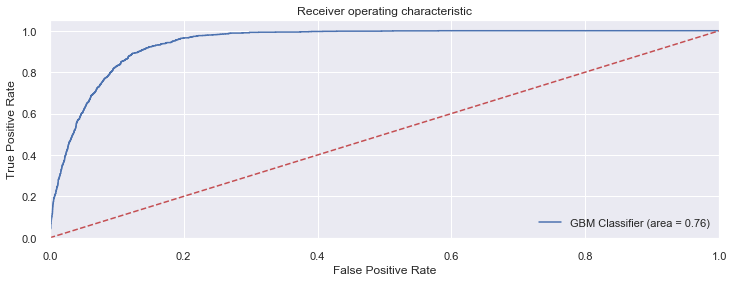

In [292]:
roc_auc = roc_auc_score(y_test, xgb_top.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, xgb_top.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='GBM Classifier (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('GBM_ROC')
plt.show()

## Feature Importance from the Best Model

Text(0, 0.5, 'Feature Importance Score')

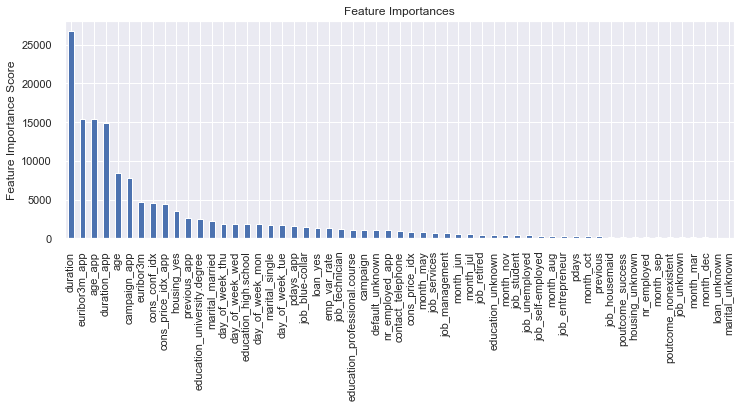

In [293]:
# display the embedded feature importance from the best model
#print_gbm_feature_importance(os_data_X, os_data_y, best_model)
feat_imp = pd.Series(xgb_top.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')